In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import unicodedata
import re
import random
import time
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")
import gc
collected_objects = gc.collect()
print(f"Garbage Collector: Freed {collected_objects} objects.")

Garbage Collector: Freed 0 objects.


Data Preparation

In [16]:
PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.n_words = 4

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def create_pairs_from_files(eng_filepath, mar_filepath):
    with open(eng_filepath, 'r', encoding='utf-8', errors='ignore') as f:
        eng_lines = f.read().strip().split('\n')
    with open(mar_filepath, 'r', encoding='utf-8', errors='ignore') as f:
        mar_lines = f.read().strip().split('\n')
    num_pairs = min(len(eng_lines), len(mar_lines))
    pairs = [[normalize_string(eng_lines[i]), normalize_string(mar_lines[i])] for i in range(num_pairs)]
    return pairs

def normalize_string(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?\u0900-\u097F]+", r" ", s)
    return s

def read_langs(lang1, lang2, pairs):
    lang1_lang = Lang(lang1)
    lang2_lang = Lang(lang2)
    for pair in pairs:
        lang1_lang.addSentence(pair[0])
        lang2_lang.addSentence(pair[1])
    return lang1_lang, lang2_lang

class TranslationDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang, max_len):
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        input_tensor = self.tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self.tensorFromSentence(self.output_lang, pair[1])
        return input_tensor, target_tensor

    def indexesFromSentence(self, lang, sentence):
        return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

    def tensorFromSentence(self, lang, sentence):
        indexes = self.indexesFromSentence(lang, sentence)
        indexes.append(EOS_token)
        padded_indexes = indexes + [PAD_token] * (self.max_len - len(indexes))
        return torch.tensor(padded_indexes, dtype=torch.long)


Model Architecture

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_dim):
        super(EncoderRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

    def forward(self, input_tensor):
        embedded = self.embedding(input_tensor)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = torch.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_dim):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.attention = Attention(hidden_size)
        self.lstm = nn.LSTM(embedding_dim + hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, device, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_cell = torch.zeros_like(decoder_hidden, device=device)
        decoder_outputs = []
        max_len = target_tensor.shape[1] if target_tensor is not None else 20
        for i in range(max_len):
            decoder_output, decoder_hidden, decoder_cell, _ = self.forward_step(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            if target_tensor is not None and random.random() < 0.5:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = torch.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input_tensor, hidden, cell, encoder_outputs):
        embedded = self.embedding(input_tensor)
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(input_lstm, (hidden, cell))
        output = self.out(output)
        return output, hidden, cell, attn_weights


Training and Translation Helpers

In [18]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, device):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data[0].to(device), data[1].to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        encoder_outputs, encoder_hidden, _ = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, device, target_tensor)
        loss = criterion(
            decoder_outputs.view(-1, decoder.out.out_features),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def translate(encoder, decoder, sentence, input_lang, output_lang, max_len, device):
    def indexesFromSentence(lang, sentence):
        return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]
    def tensorFromSentence(lang, sentence):
        indexes = indexesFromSentence(lang, sentence)
        indexes.append(EOS_token)
        padded_indexes = indexes + [PAD_token] * (max_len - len(indexes))
        return torch.tensor(padded_indexes, dtype=torch.long, device=device).view(1, -1)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_outputs, encoder_hidden, _ = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, device, None)
        decoded_words = []
        for ot in decoder_outputs[0]:
            _, topi = ot.topk(1)
            if topi.item() == EOS_token:
                break
            decoded_words.append(output_lang.index2word[topi.item()])
    return decoded_words


Visualization Utilities

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_loss_curve(losses):
    """Plots the training loss curve over epochs."""
    plt.figure(figsize=(8, 5))
    plt.plot(losses, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def visualize_attention(input_sentence, output_words, attentions):
    """Visualizes the attention weights as a heatmap."""
    # Convert input sentence to tokens
    input_tokens = input_sentence.split(' ')

    # Remove EOS token if present in output
    if output_words[-1] == '<EOS>':
        output_words = output_words[:-1]

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(attentions[:len(output_words), :len(input_tokens)], cmap='viridis')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_tokens, rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.title("Attention Heatmap", pad=20)
    plt.show()

def translate_with_attention(encoder, decoder, sentence, input_lang, output_lang, max_length, device):
    """Translates a sentence and returns predicted words & attention weights."""
    with torch.no_grad():
        # Prepare input
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = input_tensor.unsqueeze(0).to(device)  # batch_size=1
        input_length = input_tensor.size(1)

        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoder pass
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[:, ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        # Decoder start token
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, attentions[:di + 1]


Main Execution

--- Using device: cuda ---

Using the full dataset: 3625 pairs.
Filtered down to 3282 pairs.
Vocabularies built. Input: 5780 words. Output: 9643 words.

Starting training...
--- Epoch 1/10 | Time: 0m 6s | Loss: 7.4924 ---
--- Epoch 2/10 | Time: 0m 5s | Loss: 6.7789 ---
--- Epoch 3/10 | Time: 0m 6s | Loss: 6.5912 ---
--- Epoch 4/10 | Time: 0m 6s | Loss: 6.4220 ---
--- Epoch 5/10 | Time: 0m 6s | Loss: 6.2650 ---
--- Epoch 6/10 | Time: 0m 6s | Loss: 6.0853 ---
--- Epoch 7/10 | Time: 0m 6s | Loss: 5.9490 ---
--- Epoch 8/10 | Time: 0m 5s | Loss: 5.7565 ---
--- Epoch 9/10 | Time: 0m 6s | Loss: 5.5876 ---
--- Epoch 10/10 | Time: 0m 5s | Loss: 5.3559 ---
Training complete.


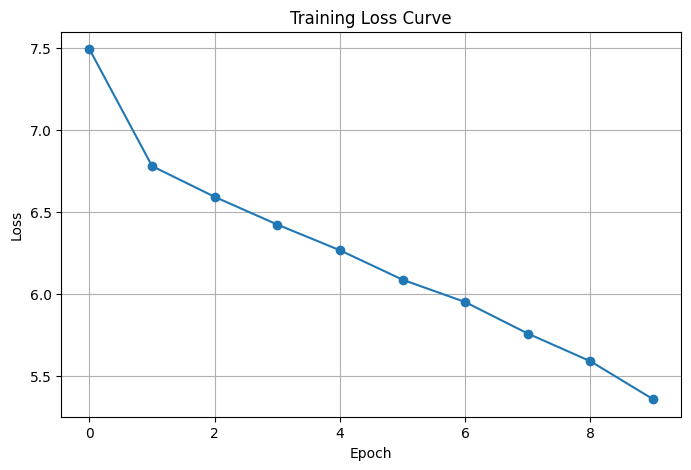

In [20]:
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Using device: {device} ---")

    # Load all sentence pairs (full dataset)
    all_pairs = create_pairs_from_files('train.en', 'train.mr')
    pairs = all_pairs
    print(f"\nUsing the full dataset: {len(pairs)} pairs.")
    del all_pairs
    gc.collect()

    # Filter pairs by length
    MAX_LENGTH = 25
    filtered_pairs = [p for p in pairs if len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH]
    if not filtered_pairs:
        raise ValueError("No sentence pairs left after filtering.")
    print(f"Filtered down to {len(filtered_pairs)} pairs.")

    # Build vocabularies
    input_lang, output_lang = read_langs('eng', 'mar', filtered_pairs)
    print("Vocabularies built. Input:", input_lang.n_words, "words. Output:", output_lang.n_words, "words.")

    # Create DataLoader
    train_dataset = TranslationDataset(filtered_pairs, input_lang, output_lang, MAX_LENGTH)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Model setup
    hidden_size = 256
    embedding_dim = 256
    encoder = EncoderRNN(input_lang.n_words, hidden_size, embedding_dim).to(device)
    decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, embedding_dim).to(device)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
    criterion = nn.NLLLoss(ignore_index=PAD_token)

    # Training loop
    print("\nStarting training...")
    n_epochs = 10
    losses = []
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, device)
        losses.append(loss)
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        print(f"--- Epoch {epoch}/{n_epochs} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s | Loss: {loss:.4f} ---")

    print("Training complete.")

    # Save for visualization block
    trained_encoder = encoder
    trained_decoder = decoder
    trained_pairs = filtered_pairs
    trained_input_lang = input_lang
    trained_output_lang = output_lang

    # Loss curve visualization
    plot_loss_curve(losses)

except FileNotFoundError:
    print("Error: Make sure 'train.en' and 'train.mr' are in the same directory as the script.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


#CONCLUSION

We implemented an English–Marathi neural machine translation model using an encoder–decoder architecture with attention. The system processed the full parallel dataset from .en and .mr files, built vocabularies, and trained over multiple epochs with loss tracking. A separate visualization module plotted the training loss curve and displayed attention heatmaps for sample translations, providing both quantitative and qualitative evaluation. This approach resulted in a functional translation model with clear insights into its learning process and translation behavior.